# Cats Vs Dogs - Transfer Learning

## Setting up the pre-trained model

We'll use the InceptionV3 pre-trained model.

In [1]:
# Download the pre-trained weights

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-09-03 13:11:02--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 64.233.170.128, 142.251.175.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  21.7MB/s    in 5.0s    

2023-09-03 13:11:07 (16.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model
# Set the input shape and remove the dense layers
pre_trained_model = InceptionV3(input_shape = (150,150,3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers
for layer in pre_trained_model.layers:
    layer.trainable = False

In [3]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

We can see that this is a very deep network. We can select up to which point of the network we want to use.
We will use upto `mixed7` layer from the pretrained model because the original last layer might be too specialized in what it has learned so it might not translate well into our application. `mixed7` will be more generalized.

In [4]:
# We'll choose 'mixed7' as the last layer of our base model
last_layer = pre_trained_model.get_layer('mixed7')
print("Last layer output shape :", last_layer.output_shape)
last_output = last_layer.output

Last layer output shape : (None, 7, 7, 768)


## Add dense layers for the classifier

In [5]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# We'll flatten the oytput layer to 1 dimension
x = layers.Flatten()(last_output)

# Now. we'll add a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Add a sigmoid layer for classification
x = layers.Dense(1, activation = 'sigmoid')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Now, print the model summary. See the dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [6]:
# Compiling the model
model.compile(optimizer = RMSprop(learning_rate = 0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

## Prepare the datset

In [7]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2023-09-03 13:11:22--  http://!wget/
Resolving !wget (!wget)... failed: Name or service not known.
wget: unable to resolve host address ‘!wget’
--2023-09-03 13:11:22--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 64.233.170.128, 142.251.175.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  19.0MB/s    in 4.4s    

2023-09-03 13:11:26 (14.9 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]

FINISHED --2023-09-03 13:11:26--
Total wall clock time: 4.8s
Downloaded: 1 files, 65M in 4.4s (14.9 MB/s)


In [8]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract
zip_ref = zipfile.ZipFile('./cats_and_dogs_filtered.zip','r')
zip_ref.extractall('tmp/')
zip_ref.close()

# Define the directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## ImageDataGenerator & Data Augmentation

In [11]:
# Add our data augmentation parameters to the ImageDatagenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Validation data should not be augmented
test_datagen = ImageDataGenerator(rescale = 1./255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150,150))

val_generator = test_datagen.flow_from_directory(validation_dir,
                                                 batch_size = 20,
                                                 class_mode = 'binary',
                                                 target_size = (150,150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Train the model

In [13]:
history = model.fit(train_generator,
                    validation_data = val_generator,
                    steps_per_epoch = 100,
                    epochs = 20,
                    validation_steps = 50,
                    verbose = 2)

Epoch 1/20
100/100 - 29s - loss: 0.3220 - accuracy: 0.8745 - val_loss: 0.1309 - val_accuracy: 0.9480 - 29s/epoch - 294ms/step
Epoch 2/20
100/100 - 21s - loss: 0.2155 - accuracy: 0.9115 - val_loss: 0.0882 - val_accuracy: 0.9660 - 21s/epoch - 209ms/step
Epoch 3/20
100/100 - 16s - loss: 0.1878 - accuracy: 0.9210 - val_loss: 0.1682 - val_accuracy: 0.9340 - 16s/epoch - 155ms/step
Epoch 4/20
100/100 - 16s - loss: 0.1551 - accuracy: 0.9355 - val_loss: 0.0995 - val_accuracy: 0.9610 - 16s/epoch - 160ms/step
Epoch 5/20
100/100 - 17s - loss: 0.1571 - accuracy: 0.9380 - val_loss: 0.1006 - val_accuracy: 0.9600 - 17s/epoch - 172ms/step
Epoch 6/20
100/100 - 17s - loss: 0.1564 - accuracy: 0.9395 - val_loss: 0.0903 - val_accuracy: 0.9660 - 17s/epoch - 165ms/step
Epoch 7/20
100/100 - 16s - loss: 0.1574 - accuracy: 0.9445 - val_loss: 0.1084 - val_accuracy: 0.9590 - 16s/epoch - 160ms/step
Epoch 8/20
100/100 - 26s - loss: 0.1426 - accuracy: 0.9455 - val_loss: 0.1665 - val_accuracy: 0.9470 - 26s/epoch - 259

## Evaluate the results

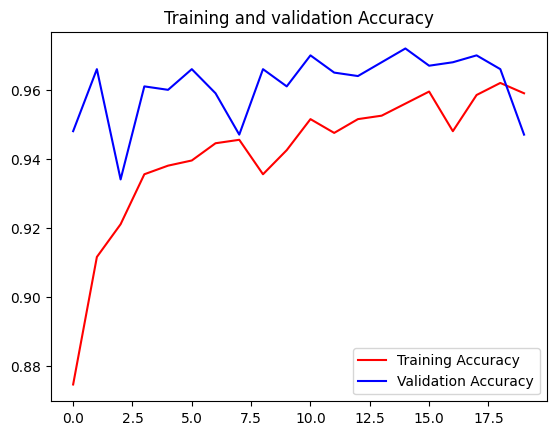

<Figure size 640x480 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training Accuracy')        # 'r' - red
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')  # 'b' - blue
plt.title('Training and validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()